In [1]:
# 📦 Cell 1: Imports
import os
from pymongo import MongoClient
import pandas as pd
from dotenv import load_dotenv
import json

load_dotenv()

True

In [3]:
# 🔐 Cell 2: SSH tunnel and MongoDB connection settings
USE_SSH = True  # Set to False if no SSH tunnel is needed

MONGO_HOST = "127.0.0.1"
MONGO_PORT = 27017
DB_NAME = "audio-analyzer-prod"  # replace with your DB name
COLLECTION_NAME = "testsubjects"  # or TestSubject if not pluralized

# SSH Config
SSH_HOST = "appskynote.com"
SSH_PORT = 22
SSH_USER = os.getenv("VPS_USERNAME")
SSH_KEY_PATH = os.getenv("VPS_PRIVATE_KEY")

REMOTE_BIND_ADDRESS = ("127.0.0.1", 27017)

In [4]:
# 🌐 Cell 4: Connect to MongoDB with authentication from .env
MONGO_URI = os.getenv("PROD_DB_URL")  # or DEV_DB_URL depending on your environment

# Use authenticated URI (it will automatically use SSH tunnel if port is forwarded)
client = MongoClient(MONGO_URI)
db = client[DB_NAME]
collection = db[COLLECTION_NAME]

# Only get documents where `data.questionnaireAnswers` exists
cursor = collection.find({"data.questionnaireAnswers": {"$exists": True}})
docs = list(cursor)

print(f"Retrieved {len(docs)} documents with questionnaireAnswers.")

Retrieved 5 documents with questionnaireAnswers.


In [ ]:
# 🌐 Export all data from the production database to a JSON file
from bson import ObjectId

# Custom JSON encoder to handle ObjectId
class JSONEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, ObjectId):
            return str(o)  # Convert ObjectId to string
        return super().default(o)

# Fetch all documents from the collection
all_docs_cursor = collection.find()
all_docs = list(all_docs_cursor)

# Define the output file path
output_file_path = "old_data.json"

# Save the data to a JSON file
with open(output_file_path, "w") as json_file:
    json.dump(all_docs, json_file, indent=4, cls=JSONEncoder)

print(f"✅ All data has been saved to {output_file_path}.")

TypeError: Object of type ObjectId is not JSON serializable

In [4]:
def flatten_doc(doc):
    flat = {
        "subjectId": doc.get("subjectId"),
        "createdAt": doc.get("createdAt"),
    }

    # Include all top-level keys from data
    data = doc.get("data", {})
    for key, value in data.items():
        flat[f"data.{key}"] = value

    return flat

rows = [flatten_doc(doc) for doc in docs]
df = pd.DataFrame(rows)
df.head()

,subjectId,createdAt,data.consent,data.subjectId,data.musicExperience,data.none,data.feedback,data.questionnaireAnswers,data.firstRound
0,az1x7ytn,2025-07-01 16:38:02.776,True,az1x7ytn,Beginner,{'pitch': {'subject-az1x7ytn-none-pitch-1.wav'...,{'before': {'pitch': {'subject-az1x7ytn-feedba...,{'experience': 'I liked that there were certai...,NaN
1,nv2lqft2,2025-07-01 18:11:25.821,True,nv2lqft2,Advanced,{'pitch': {'subject-nv2lqft2-none-pitch-1.wav'...,{'before': {'pitch': {'subject-nv2lqft2-feedba...,{'experience': 'I enjoyed using it. It gave me...,NaN
2,ee2xq66p,2025-07-02 10:35:30.226,True,ee2xq66p,Advanced,{'pitch': {'subject-ee2xq66p-none-pitch-1.wav'...,{'before': {'pitch': {'subject-ee2xq66p-feedba...,{'experience': 'I enjoyed using the audio anal...,NaN
3,e3c1bd68,2025-07-03 09:23:59.070,True,e3c1bd68,Professional,{'pitch': {'subject-e3c1bd68-none-pitch-1.wav'...,{'before': {'pitch': {'subject-e3c1bd68-feedba...,{'experience': 'I liked the pitch visuallizati...,NaN
4,eamv7woj,2025-07-07 14:53:20.255,True,eamv7woj,Advanced,{'pitch': {'subject-eamv7woj-none-pitch-1.wav'...,{'before': {'pitch': {'subject-eamv7woj-feedba...,{'experience': 'Great experience. Loved the pi...,none


In [5]:
# 🧼 Clean and extract rating comparisons for each feature
def extract_ratings(doc):
    subject_id = doc.get("subjectId")
    data = doc.get("data", {})
    
    if "none" not in data or "feedback" not in data:
        return None  # Skip if essential keys missing

    feedback = data["feedback"]
    none = data["none"]

    features = ["pitch", "dynamics", "tempo"]
    rows = []

    for feature in features:
        try:
            none_rating = none[feature].get("performanceRating", None)
            before_rating = feedback.get("before", {}).get(feature, {}).get("performanceRating", None)
            after_rating = feedback.get("after", {}).get(feature, {}).get("performanceRating", None)

            rows.append({
                "subjectId": subject_id,
                "feature": feature,
                "none_rating": none_rating,
                "before_rating": before_rating,
                "after_rating": after_rating
            })
        except Exception as e:
            print(f"Skipping subject {subject_id}, feature {feature}: {e}")

    return rows

# Flatten all subject rows into a single list
rating_rows = []
for doc in docs:
    if "questionnaireAnswers" in doc.get("data", {}):
        extracted = extract_ratings(doc)
        if extracted:
            rating_rows.extend(extracted)

# Create a DataFrame
ratings_df = pd.DataFrame(rating_rows)
ratings_df


,subjectId,feature,none_rating,before_rating,after_rating
0,az1x7ytn,pitch,5,5,4
1,az1x7ytn,dynamics,4,6,6
2,az1x7ytn,tempo,6,4,5
3,nv2lqft2,pitch,5,8,8
4,nv2lqft2,dynamics,5,5,6
5,nv2lqft2,tempo,5,6,6
6,ee2xq66p,pitch,7,7,9
7,ee2xq66p,dynamics,6,7,7
8,ee2xq66p,tempo,6,6,7
9,e3c1bd68,pitch,8,9,8


In [6]:
ratings_long = pd.melt(
    ratings_df,
    id_vars=["subjectId", "feature"],
    value_vars=["none_rating", "before_rating", "after_rating"],
    var_name="condition",
    value_name="rating"
)

# Clean up the condition names
ratings_long["condition"] = ratings_long["condition"].str.replace("_rating", "")
ratings_long.head()

,subjectId,feature,condition,rating
0,az1x7ytn,pitch,none,5
1,az1x7ytn,dynamics,none,4
2,az1x7ytn,tempo,none,6
3,nv2lqft2,pitch,none,5
4,nv2lqft2,dynamics,none,5


In [7]:
from statsmodels.stats.anova import AnovaRM

anova_results = []

for feature in ratings_long["feature"].unique():
    subset = ratings_long[ratings_long["feature"] == feature]

    # Drop missing ratings
    subset = subset.dropna()

    # Run repeated measures ANOVA
    anova = AnovaRM(subset, depvar='rating', subject='subjectId', within=['condition'])
    result = anova.fit()
    
    print(f"\n=== Repeated Measures ANOVA for {feature.upper()} ===")
    print(result)

    anova_results.append((feature, result))



=== Repeated Measures ANOVA for PITCH ===
                Anova
          F Value Num DF Den DF Pr > F
--------------------------------------
condition  1.6716 2.0000 8.0000 0.2474


=== Repeated Measures ANOVA for DYNAMICS ===
                Anova
          F Value Num DF Den DF Pr > F
--------------------------------------
condition  4.7500 2.0000 8.0000 0.0437


=== Repeated Measures ANOVA for TEMPO ===
                Anova
          F Value Num DF Den DF Pr > F
--------------------------------------
condition  1.8065 2.0000 8.0000 0.2252



In [8]:
from scipy.stats import ttest_rel

for feature in ratings_df["feature"].unique():
    df = ratings_df[ratings_df["feature"] == feature].dropna()

    print(f"\n=== Paired t-tests for {feature.upper()} ===")

    t1, p1 = ttest_rel(df["none_rating"], df["before_rating"])
    print(f"none vs before: t = {t1:.3f}, p = {p1:.4f}")

    t2, p2 = ttest_rel(df["none_rating"], df["after_rating"])
    print(f"none vs after:  t = {t2:.3f}, p = {p2:.4f}")

    t3, p3 = ttest_rel(df["before_rating"], df["after_rating"])
    print(f"before vs after: t = {t3:.3f}, p = {p3:.4f}")


=== Paired t-tests for PITCH ===
none vs before: t = -1.372, p = 0.2420
none vs after:  t = -1.633, p = 0.1778
before vs after: t = -0.590, p = 0.5870

=== Paired t-tests for DYNAMICS ===
none vs before: t = -1.500, p = 0.2080
none vs after:  t = -3.162, p = 0.0341
before vs after: t = -1.633, p = 0.1778

=== Paired t-tests for TEMPO ===
none vs before: t = 1.372, p = 0.2420
none vs after:  t = -0.667, p = 0.5415
before vs after: t = -1.633, p = 0.1778


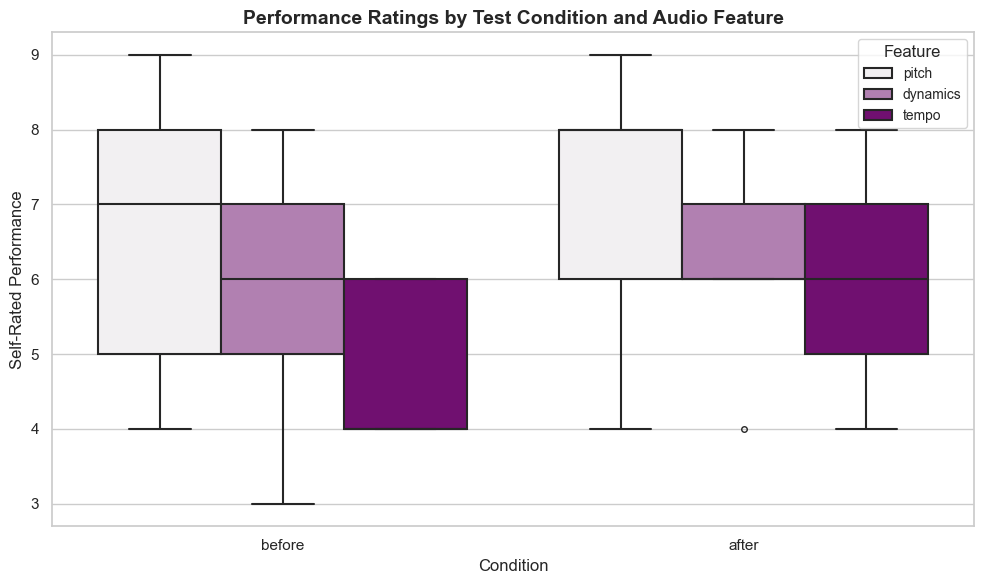

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a custom pastel purple palette for the three features
pastel_purples = sns.light_palette("purple", n_colors=3)

# Set seaborn style
sns.set_theme(style="whitegrid")

filtered_ratings_long = ratings_long[ratings_long["condition"].isin(["before", "after"])]


plt.figure(figsize=(10, 6))

# Draw the boxplot using the custom palette
sns.boxplot(
    data=filtered_ratings_long,
    x="condition",
    y="rating",
    hue="feature",
    palette=pastel_purples,
    linewidth=1.5,
    fliersize=4  # size of the outliers
)

# Title and labels
plt.title("Performance Ratings by Test Condition and Audio Feature", fontsize=14, weight='bold')
plt.xlabel("Condition", fontsize=12)
plt.ylabel("Self-Rated Performance", fontsize=12)

# Customize legend
plt.legend(title="Feature", title_fontsize='12', fontsize='10', loc='upper right')

# Tidy layout
plt.tight_layout()

# Save the figure with a transparent background before showing it
plt.savefig("performance_ratings_transparent.png", transparent=True, bbox_inches='tight')

plt.show()

In [18]:
# 📝 Create a DataFrame for questionnaire answers
questionnaire_rows = []
for doc in docs:
    data = doc.get("data", {})
    answers = data.get("questionnaireAnswers")
    
    if answers:
        # Start with the subjectId
        row = {"subjectId": doc.get("subjectId")}
        # Add all questionnaire answers to the row
        row.update(answers)
        questionnaire_rows.append(row)

questionnaire_df = pd.DataFrame(questionnaire_rows)

output_json_path = 'questionnaire_data.json'
questionnaire_df.to_json(output_json_path, orient='records', indent=4)

questionnaire_df.head()

,subjectId,experience,improvement,payment
0,az1x7ytn,I liked that there were certain areas highligh...,The dynamics part helped me because I could vi...,I personally wouldn't because I'm not a musici...
1,nv2lqft2,I enjoyed using it. It gave me insightful feed...,It allowed to me pinpoint where I am making mi...,I would back maximum 10 dollars a month for su...
2,ee2xq66p,"I enjoyed using the audio analyzer, but I woul...","I do think it helped, as it made me more aware...","If the analysis was a bit more in depth, with ..."
3,e3c1bd68,"I liked the pitch visuallization, i think it i...","I think it helped, as I was more conscious of ...","With more futures definately, something like a..."


In [10]:
# Download & organize remote audio files via SFTP
import paramiko

# reuse your SSH settings from above
# SSH_HOST, SSH_PORT, SSH_USER, SSH_KEY_PATH

# where to dump everything locally
LOCAL_BASE = "./downloaded_audios"
REMOTE_BASE = "/home/isabelle/audio-analyzer/python-service/static/audio/testing"

os.makedirs(LOCAL_BASE, exist_ok=True)

def collect_paths(doc):
    """Recursively find all filePath values in doc['data']."""
    paths = []
    def _walk(d, subj):
        if isinstance(d, dict):
            for k, v in d.items():
                if k == "filePath":
                    remote = v
                    # mirror remote structure under LOCAL_BASE/subjectId
                    rel = os.path.relpath(remote, REMOTE_BASE)
                    local = os.path.join(LOCAL_BASE, subj, rel)
                    paths.append((remote, local))
                else:
                    _walk(v, subj)
    _walk(doc.get("data", {}), doc["subjectId"])
    return paths

In [11]:
# open SSH→SFTP
key = paramiko.RSAKey.from_private_key_file(SSH_KEY_PATH)
ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect(SSH_HOST, port=SSH_PORT, username=SSH_USER, pkey=key)
sftp = ssh.open_sftp()

for doc in docs:
    for remote_path, local_path in collect_paths(doc):
        os.makedirs(os.path.dirname(local_path), exist_ok=True)
        print(f"Fetching {remote_path} → {local_path}")
        sftp.get(remote_path, local_path)

sftp.close()
ssh.close()
print("✅ All files downloaded.")

Fetching /home/isabelle/audio-analyzer/python-service/static/audio/testing/none/pitch/subject-az1x7ytn-none-pitch-1.wav → ./downloaded_audios/az1x7ytn/none/pitch/subject-az1x7ytn-none-pitch-1.wav
Fetching /home/isabelle/audio-analyzer/python-service/static/audio/testing/none/pitch/subject-az1x7ytn-none-pitch-2.wav → ./downloaded_audios/az1x7ytn/none/pitch/subject-az1x7ytn-none-pitch-2.wav
Fetching /home/isabelle/audio-analyzer/python-service/static/audio/testing/none/dynamics/subject-az1x7ytn-none-dynamics-1.wav → ./downloaded_audios/az1x7ytn/none/dynamics/subject-az1x7ytn-none-dynamics-1.wav
Fetching /home/isabelle/audio-analyzer/python-service/static/audio/testing/none/dynamics/subject-az1x7ytn-none-dynamics-2.wav → ./downloaded_audios/az1x7ytn/none/dynamics/subject-az1x7ytn-none-dynamics-2.wav
Fetching /home/isabelle/audio-analyzer/python-service/static/audio/testing/none/dynamics/subject-az1x7ytn-none-dynamics-3.wav → ./downloaded_audios/az1x7ytn/none/dynamics/subject-az1x7ytn-none